In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# 당진 예보 데이터 전처리 & 선형보간

In [87]:
dangjin_fcst = pd.read_csv('../../../data/solar_energy2/dangjin_fcst_data.csv')

In [88]:
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0


In [89]:
# 예보 시간 컬럼의 데이터 타입을 datetime으로 변경합니다.
# 기상청에서는 하루 3시간 간격으로 8회 예보합니다.
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0,2018-03-01 11:00:00
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0,2018-03-01 11:00:00
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0,2018-03-01 11:00:00
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0,2018-03-01 11:00:00
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0,2018-03-01 11:00:00
...,...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0,2021-03-01 08:00:00
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0,2021-03-01 08:00:00
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0,2021-03-01 08:00:00
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0,2021-03-01 08:00:00


In [90]:
# 14시 예보만을 사용하였습니다
fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
fcst_14

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
20,2018-03-01 14:00:00,4.0,-2.0,60.0,7.1,314.0,1.0,2018-03-01 14:00:00
21,2018-03-01 14:00:00,7.0,-2.0,60.0,6.7,323.0,1.0,2018-03-01 14:00:00
22,2018-03-01 14:00:00,10.0,-2.0,55.0,6.7,336.0,1.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-4.0,55.0,5.5,339.0,1.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-5.0,60.0,4.3,344.0,1.0,2018-03-01 14:00:00
...,...,...,...,...,...,...,...,...
162094,2021-02-28 14:00:00,46.0,4.0,50.0,5.8,344.0,1.0,2021-02-28 14:00:00
162095,2021-02-28 14:00:00,49.0,5.0,50.0,5.9,333.0,1.0,2021-02-28 14:00:00
162096,2021-02-28 14:00:00,52.0,3.0,60.0,4.1,311.0,1.0,2021-02-28 14:00:00
162097,2021-02-28 14:00:00,55.0,1.0,80.0,1.7,329.0,1.0,2021-02-28 14:00:00


In [91]:
# 다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(00:00)부터 33시간 후(23:00) 데이터만 사용합니다.
fcst_14 = fcst_14[fcst_14['forecast']>=10]
fcst_14 = fcst_14[fcst_14['forecast']<=33]
fcst_14

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,-2.0,55.0,6.7,336.0,1.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-4.0,55.0,5.5,339.0,1.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-5.0,60.0,4.3,344.0,1.0,2018-03-01 14:00:00
25,2018-03-01 14:00:00,19.0,-2.0,55.0,2.0,345.0,1.0,2018-03-01 14:00:00
26,2018-03-01 14:00:00,22.0,1.0,45.0,0.8,256.0,1.0,2018-03-01 14:00:00
...,...,...,...,...,...,...,...,...
162085,2021-02-28 14:00:00,19.0,8.0,90.0,3.9,64.0,4.0,2021-02-28 14:00:00
162086,2021-02-28 14:00:00,22.0,10.0,90.0,4.8,7.0,4.0,2021-02-28 14:00:00
162087,2021-02-28 14:00:00,25.0,10.0,85.0,6.6,11.0,4.0,2021-02-28 14:00:00
162088,2021-02-28 14:00:00,28.0,7.0,85.0,6.5,34.0,4.0,2021-02-28 14:00:00


In [92]:
# 예보 시점에 focast를 더하여 예보 시각을 구합니다.
def to_date(x):
    return pd.DateOffset(hours=x)

fcst_14['Forecast_time'] = fcst_14['Forecast_time'] + fcst_14['forecast'].map(to_date)
fcst_14

C:\Users\nammr\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,-2.0,55.0,6.7,336.0,1.0,2018-03-02 00:00:00
23,2018-03-01 14:00:00,13.0,-4.0,55.0,5.5,339.0,1.0,2018-03-02 03:00:00
24,2018-03-01 14:00:00,16.0,-5.0,60.0,4.3,344.0,1.0,2018-03-02 06:00:00
25,2018-03-01 14:00:00,19.0,-2.0,55.0,2.0,345.0,1.0,2018-03-02 09:00:00
26,2018-03-01 14:00:00,22.0,1.0,45.0,0.8,256.0,1.0,2018-03-02 12:00:00
...,...,...,...,...,...,...,...,...
162085,2021-02-28 14:00:00,19.0,8.0,90.0,3.9,64.0,4.0,2021-03-01 09:00:00
162086,2021-02-28 14:00:00,22.0,10.0,90.0,4.8,7.0,4.0,2021-03-01 12:00:00
162087,2021-02-28 14:00:00,25.0,10.0,85.0,6.6,11.0,4.0,2021-03-01 15:00:00
162088,2021-02-28 14:00:00,28.0,7.0,85.0,6.5,34.0,4.0,2021-03-01 18:00:00


In [93]:
fcst_14 = fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
fcst_14.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
23,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
24,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0
25,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0
26,2018-03-02 12:00:00,1.0,45.0,0.8,256.0,1.0


태양광 발전량 예측은 1시간 간격으로 해야하나 예보는 3시간 간격으로 나옵니다.    
간단한 선형보간법을 활용하여 비어있는 값을 채우겠습니다.

In [94]:
fcst_14_ = pd.DataFrame()
fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')
fcst_14_

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00
...,...
26299,2021-03-01 19:00:00
26300,2021-03-01 20:00:00
26301,2021-03-01 21:00:00
26302,2021-03-01 22:00:00


In [95]:
# 기존 예보 데이터프레임과 병합합니다.
fcst_14_ = pd.merge(fcst_14_, fcst_14, on='Forecast_time', how='outer')
fcst_14_

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN
26300,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


pandas에서 지원하는 interpolate함수를 활용하여 선형보간합니다.

In [96]:
inter_fcst_14 = fcst_14_.interpolate()
inter_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0


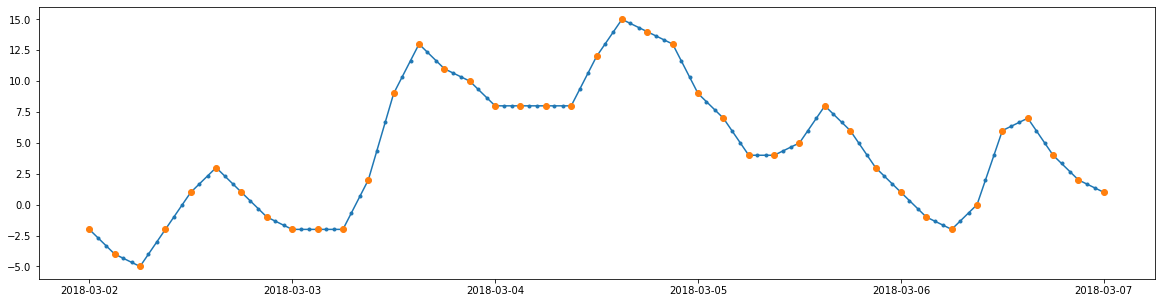

In [97]:
# 보간 결과 시각화
plt.figure(figsize=(20,5))
days = 5
plt.plot(inter_fcst_14.loc[:24*days, 'Forecast_time'], inter_fcst_14.loc[:24*days, 'Temperature'], '.-')
plt.plot(fcst_14_.loc[:24*days, 'Forecast_time'], fcst_14_.loc[:24*days, 'Temperature'], 'o')

In [98]:
inter_fcst_14.to_csv('../../../data/solar_energy2/dangjin_fcst.csv', index=False)


---

# 울산 예보 데이터 전처리와 선형보간

In [99]:
ulsan_fcst = pd.read_csv('../../../data/solar_energy2/ulsan_fcst_data.csv')
ulsan_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,9.0,45.0,3.1,83.0,3.0
162204,2021-03-01 08:00:00,55.0,9.0,45.0,3.0,111.0,3.0
162205,2021-03-01 08:00:00,58.0,8.0,55.0,2.2,122.0,3.0
162206,2021-03-01 08:00:00,61.0,6.0,65.0,0.9,131.0,3.0


In [100]:
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])
ulsan_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0,2018-03-01 11:00:00
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0,2018-03-01 11:00:00
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0,2018-03-01 11:00:00
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 11:00:00
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 11:00:00
...,...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,9.0,45.0,3.1,83.0,3.0,2021-03-01 08:00:00
162204,2021-03-01 08:00:00,55.0,9.0,45.0,3.0,111.0,3.0,2021-03-01 08:00:00
162205,2021-03-01 08:00:00,58.0,8.0,55.0,2.2,122.0,3.0,2021-03-01 08:00:00
162206,2021-03-01 08:00:00,61.0,6.0,65.0,0.9,131.0,3.0,2021-03-01 08:00:00


In [101]:
u_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]
u_fcst_14

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
20,2018-03-01 14:00:00,4.0,4.0,20.0,4.3,298.0,2.0,2018-03-01 14:00:00
21,2018-03-01 14:00:00,7.0,3.0,30.0,1.9,309.0,2.0,2018-03-01 14:00:00
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-01 14:00:00
...,...,...,...,...,...,...,...,...
162094,2021-02-28 14:00:00,46.0,7.0,60.0,10.0,7.0,4.0,2021-02-28 14:00:00
162095,2021-02-28 14:00:00,49.0,7.0,50.0,10.0,15.0,4.0,2021-02-28 14:00:00
162096,2021-02-28 14:00:00,52.0,6.0,50.0,10.0,21.0,4.0,2021-02-28 14:00:00
162097,2021-02-28 14:00:00,55.0,4.0,55.0,4.8,15.0,3.0,2021-02-28 14:00:00


In [102]:
# 다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(00:00)부터 33시간 후(23:00) 데이터만 사용합니다.
u_fcst_14 = u_fcst_14[u_fcst_14['forecast']>=10]
u_fcst_14 = u_fcst_14[u_fcst_14['forecast']<=33]
u_fcst_14

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-01 14:00:00
25,2018-03-01 14:00:00,19.0,0.0,35.0,1.9,321.0,1.0,2018-03-01 14:00:00
26,2018-03-01 14:00:00,22.0,6.0,30.0,1.4,324.0,1.0,2018-03-01 14:00:00
...,...,...,...,...,...,...,...,...
162085,2021-02-28 14:00:00,19.0,15.0,80.0,2.9,149.0,4.0,2021-02-28 14:00:00
162086,2021-02-28 14:00:00,22.0,17.0,70.0,5.1,156.0,4.0,2021-02-28 14:00:00
162087,2021-02-28 14:00:00,25.0,17.0,75.0,3.5,167.0,4.0,2021-02-28 14:00:00
162088,2021-02-28 14:00:00,28.0,16.0,80.0,4.3,39.0,4.0,2021-02-28 14:00:00


In [103]:
def to_date(x):
    return pd.DateOffset(hours=x)

u_fcst_14['Forecast_time'] = u_fcst_14['Forecast_time'] + u_fcst_14['forecast'].map(to_date)
u_fcst_14

C:\Users\nammr\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-02 00:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-02 03:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-02 06:00:00
25,2018-03-01 14:00:00,19.0,0.0,35.0,1.9,321.0,1.0,2018-03-02 09:00:00
26,2018-03-01 14:00:00,22.0,6.0,30.0,1.4,324.0,1.0,2018-03-02 12:00:00
...,...,...,...,...,...,...,...,...
162085,2021-02-28 14:00:00,19.0,15.0,80.0,2.9,149.0,4.0,2021-03-01 09:00:00
162086,2021-02-28 14:00:00,22.0,17.0,70.0,5.1,156.0,4.0,2021-03-01 12:00:00
162087,2021-02-28 14:00:00,25.0,17.0,75.0,3.5,167.0,4.0,2021-03-01 15:00:00
162088,2021-02-28 14:00:00,28.0,16.0,80.0,4.3,39.0,4.0,2021-03-01 18:00:00


In [104]:
u_fcst_14 = u_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
u_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,0.0,40.0,1.5,318.0,2.0
23,2018-03-02 03:00:00,-1.0,45.0,1.8,308.0,2.0
24,2018-03-02 06:00:00,-2.0,45.0,1.7,294.0,1.0
25,2018-03-02 09:00:00,0.0,35.0,1.9,321.0,1.0
26,2018-03-02 12:00:00,6.0,30.0,1.4,324.0,1.0
...,...,...,...,...,...,...
162085,2021-03-01 09:00:00,15.0,80.0,2.9,149.0,4.0
162086,2021-03-01 12:00:00,17.0,70.0,5.1,156.0,4.0
162087,2021-03-01 15:00:00,17.0,75.0,3.5,167.0,4.0
162088,2021-03-01 18:00:00,16.0,80.0,4.3,39.0,4.0


In [105]:
u_fcst_14_ = pd.DataFrame()
u_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')
u_fcst_14_

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00
...,...
26299,2021-03-01 19:00:00
26300,2021-03-01 20:00:00
26301,2021-03-01 21:00:00
26302,2021-03-01 22:00:00


In [106]:
u_fcst_14_ = pd.merge(u_fcst_14_, u_fcst_14, on='Forecast_time', how='outer')
u_fcst_14_

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.0,40.0,1.5,318.0,2.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-1.0,45.0,1.8,308.0,2.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN
26300,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN
26301,2021-03-01 21:00:00,14.0,80.0,6.7,15.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [107]:
u_inter_fcst_14 = u_fcst_14_.interpolate()
u_inter_fcst_14 

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,15.333333,80.000000,5.100000,31.000000,4.000000
26300,2021-03-01 20:00:00,14.666667,80.000000,5.900000,23.000000,4.000000
26301,2021-03-01 21:00:00,14.000000,80.000000,6.700000,15.000000,4.000000
26302,2021-03-01 22:00:00,14.000000,80.000000,6.700000,15.000000,4.000000


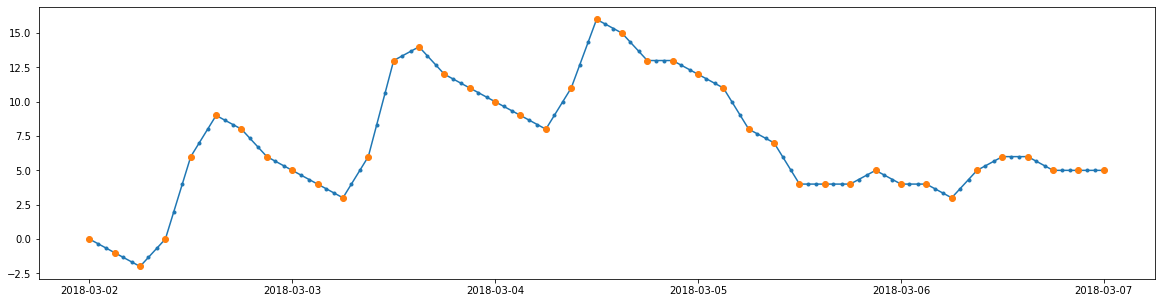

In [108]:
plt.figure(figsize=(20,5))
days = 5
plt.plot(u_inter_fcst_14.loc[:24*days, 'Forecast_time'], u_inter_fcst_14.loc[:24*days, 'Temperature'], '.-')
plt.plot(u_fcst_14_.loc[:24*days, 'Forecast_time'], u_fcst_14_.loc[:24*days, 'Temperature'], 'o')

In [ ]:
u_inter_fcst_14.to_csv('../../../data/solar_energy2/dangjin_fcst.csv', index=False)
